In [1]:
from app.services.RAGService import RAGService
from app.helpers.logger import Logger
from app.services.SQLService import SQLService
from app.services.FileService import FileService

file_path = "downloads/154.pdf"  

logger = Logger().get_logger()
sql_service = SQLService(logger)
rag_service = RAGService(logger, sql_service)
file_service = FileService(logger, sql_service, rag_service)

/home/james/MyFolder/code/hyper_aigent/hyper_aigent_services_rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rag_service.run_chain(154, "What is transformer")

page_content='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3Pk

'Based on the context provided, the Transformer is a novel neural network architecture for sequence transduction tasks, such as machine translation, that relies entirely on attention mechanisms instead of traditional recurrent or convolutional neural networks. Here are the key characteristics of the Transformer:\n\n1. Architecture:\n- Consists of an encoder and decoder stack\n- Each stack has N (6 in the original paper) identical layers\n- Uses multi-head self-attention mechanisms and fully connected feed-forward networks\n\n2. Key Innovations:\n- Replaces recurrent layers with self-attention\n- Allows for significant parallelization of computation\n- Enables modeling dependencies between input and output sequences without regard to their distance\n\n3. Advantages:\n- Can be trained faster than recurrent architectures\n- Achieves state-of-the-art performance on machine translation tasks\n- More computationally efficient, especially for longer sequences\n\n4. Core Components:\n- Multi-h

In [23]:
import os 
from app.services.SQLService import SQLService
from logging import Logger
from langchain_core.prompts import ChatPromptTemplate
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings
from langchain_postgres import PGVector
from langchain.schema.document import Document
import uuid
from langchain_core.runnables import Runnable
from typing import List
import json
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage
from app.services.utils import render_page
from collections import defaultdict

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_MODEL_NAME = os.getenv("OPENAI_MODEL_NAME")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
PG_VECTOR_CONNECTION_STRING = os.getenv("PG_VECTOR_CONNECTION_STRING")
TOP_K = os.getenv("TOP_K", 3)

class CustomRetriever(Runnable):
    def __init__(self, file_id, embeddings: OpenAIEmbeddings, sql_service: SQLService, vector_store: PGVector, threshold=0.5, id_key="chunk_id"):
        self.file_id = file_id
        self.embeddings = embeddings
        self.sql_service = sql_service
        self.vector_store = vector_store
        self.threshold = threshold
        self.id_key = id_key

    def invoke(self, input: str, config: dict = None) -> List[Document]:
        # Step 1: Search vector DB
        retrieved = self.vector_store.similarity_search_with_score(input, k=TOP_K)
        filtered = [doc for doc, score in retrieved if score >= self.threshold]
        chunk_ids = [doc.metadata[self.id_key] for doc in filtered]

        # Step 2: Get full original content
        result = defaultdict(list)  # page_number -> List[Document]
        
        for chunk_id in chunk_ids:
            db_result = self.sql_service.execute_query(
                f"SELECT * FROM public.rag_original_chunks WHERE chunk_id = %s",
                (chunk_id,),
                fetchone=True
            )
            
            if not db_result:
                continue
            
            
            content = db_result[4]
            chunk_type = db_result[3]
            
            if chunk_type == "image":
                elm = json.loads(content)
                metadata = elm["metadata"]
                
                page_content = metadata.get("image_base64", "")
                coordinates = metadata.get("coordinates", {})
                page_number = metadata.get("page_number", 0)
                
                doc = Document(
                    page_content=page_content,
                    metadata={
                        "type": "Image",
                        "coordinates": coordinates,
                        "page_number": page_number
                    }
                )
                result[page_number].append(doc)
            else:
                elememnts = json.loads(content)
                for elm in elememnts:
                    metadata = elm["metadata"]
                    
                    page_content = elm.get("text", "")
                    coordinates = metadata.get("coordinates", {})
                    page_number = metadata.get("page_number", 0)
                    
                    doc = Document(
                        page_content=page_content,
                        metadata={
                            "type": elm["type"],
                            "coordinates": coordinates,
                            "page_number": page_number
                        }
                    )
                    result[page_number].append(doc)
        return dict(result)
    
embeddings = OpenAIEmbeddings(model="text-embedding-3-large", api_key=OPENAI_API_KEY)

vector_store = PGVector(
    embeddings=embeddings,
    collection_name=str(153),
    connection=PG_VECTOR_CONNECTION_STRING,
)

retriever = CustomRetriever(
    file_id=153,
    embeddings=embeddings,
    sql_service=sql_service,
    vector_store=vector_store)

results  = retriever.invoke("Who is Ky CUong?")

print(results.keys())

results

dict_keys([1, 2])


{1: [Document(metadata={'type': 'UncategorizedText', 'coordinates': {'points': [[14.0, 35.0], [14.0, 75.0], [1679.0, 75.0], [1679.0, 35.0]], 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'page_number': 1}, page_content='EEE")'),
  Document(metadata={'type': 'Title', 'coordinates': {'points': [[75.59166666666667, 125.0019302368164], [75.59166666666667, 206.1730444444445], [403.37091064453125, 206.1730444444445], [403.37091064453125, 125.0019302368164]], 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'page_number': 1}, page_content='INVOICE'),
  Document(metadata={'type': 'NarrativeText', 'coordinates': {'points': [[75.59166666666667, 251.4939422607422], [75.59166666666667, 276.66951111111126], [249.8423614501953, 276.66951111111126], [249.8423614501953, 251.4939422607422]], 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'page_number': 1}, page_content='Ky Cuong Pham'),
  Document(metadata={'type': 'Header', 'coordinat

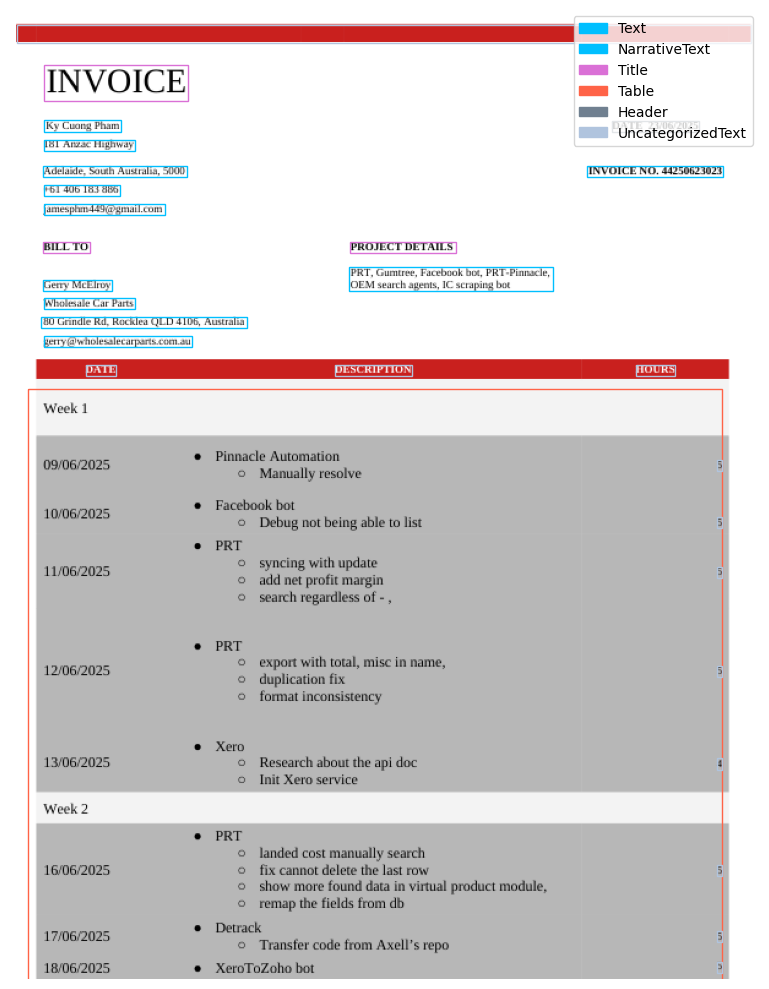

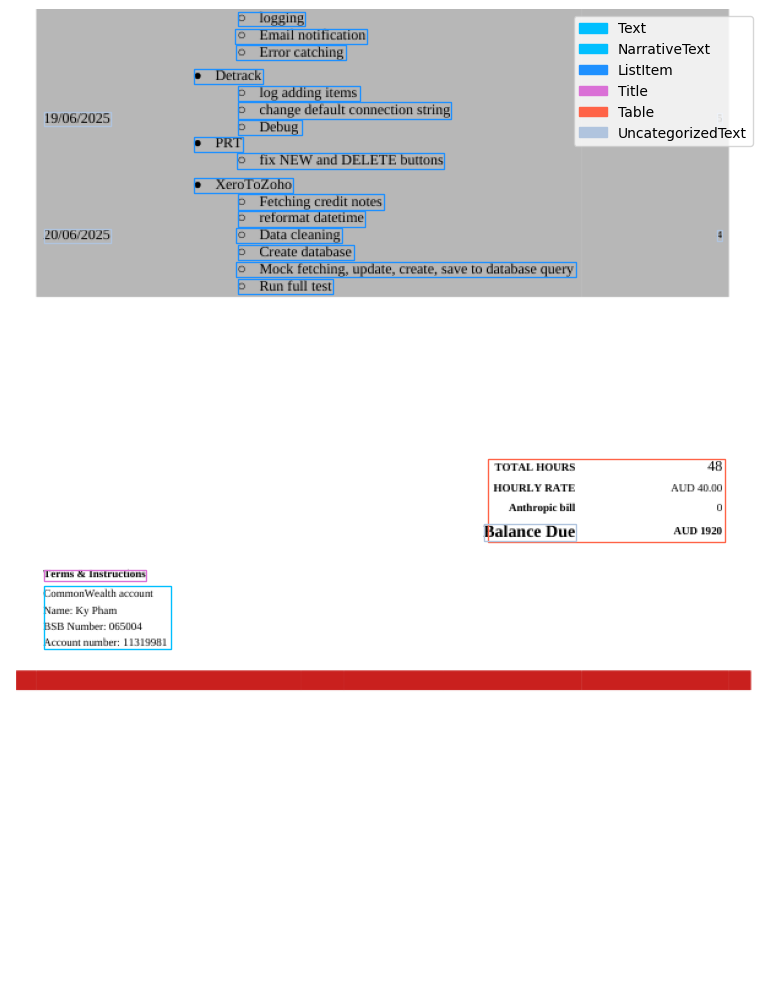

{'images': [],
 'texts': ['UncategorizedText: EEE")',
  'Title: INVOICE',
  'NarrativeText: Ky Cuong Pham',
  'Header: DATE 23/06/2025',
  'NarrativeText: 181 Anzac Highway',
  'NarrativeText: Adelaide, South Australia, 5000',
  'NarrativeText: INVOICE NO. 44250623023',
  'NarrativeText: +61 406 183 886',
  'NarrativeText: jamesphm449@gmail.com',
  'Title: BILL TO',
  'Title: PROJECT DETAILS',
  'NarrativeText: Gerry McElroy',
  'NarrativeText: PRT, Gumtree, Facebook bot, PRT-Pinnacle, OEM search agents, IC scraping bot',
  'NarrativeText: Wholesale Car Parts',
  'NarrativeText: 80 Grindle Rd, Rocklea QLD 4106, Australia',
  'NarrativeText: gerry@wholesalecarparts.com.au',
  'UncategorizedText: DATE',
  'UncategorizedText: DESCRIPTION',
  'UncategorizedText: HOURS',
  'Table: Week 1 09/06/2025 ● Pinnacle Automation ○ Manually resolve 10/06/2025 ● Facebook bot ○ Debug not being able to list ● PRT 11/06/2025 ○ syncing with update ○ add net profit margin ○ search regardless of - , ● PRT 1

In [24]:
from app.services.utils import render_page


def parse_docs(retriever_results: dict) -> dict:
    images = []
    texts = []
    
    for page_number, docs in retriever_results.items():
        
        render_page(153, docs, page_number, False)
        
        for doc in docs:
            if doc.metadata.get("type") == "Image":
                images.append(doc.page_content)
            else:
                type_and_text = f"{doc.metadata.get('type')}: {doc.page_content}"
                texts.append(type_and_text)
    return {"images": images, "texts": texts}

parse_docs(results)